This script can be used to do preprocessing of the fundus images from different databases. The images can have different formats as an input to the preprocessing functions and will eventually be turned into numpy arrays and stored in this format.

For every database a train and test numpy array is generated together with a numpy array containing the corresponding annotation files for training and testing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from skimage.transform import resize
import pandas as pd
from sklearn.model_selection import train_test_split
from resizeimage import resizeimage
import cv2

The functions below can be used to turn every image into a numpy array and to do preprocessing of the images. The preprocessing function at the end brings all preprocessing steps for one image together.

In [2]:
def LoadImage(filepath):
    '''Load an image indicated by the filepath and turn it into a numpy array'''
    im = Image.open(filepath)
    im_array = np.asarray(im)
    
    return im_array

In [3]:
def PlotImage(image_array, database = '', image_name = '', save = False, savepath = ''):
    '''Visualize (and save if desired) an image represented by a numpy array'''
    
    plt.figure()
    plt.title(database+': '+image_name)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.imshow(image_array, cmap=plt.cm.Greys_r)
    
    if save == True:
        plt.savefig(savepath+database+'_'+image_name+'.png')
    
    return 

In [4]:
def FindMask(image_array):
    '''
    defining a binary mask that delineates the retina on the image
    simple thresholding is used for this procedure
    '''
    mask = np.zeros(image_array.shape[0:2])
    
    # in the red channel the difference between background and retina is the largest
    # a threshold of 50 is used, as defined from the histogram below
    red_channel = SelectChannel(image_array, 'R')
    
    # linear contrast mapping is performed when the full intensity range is not used
    intensity_range = np.unique(red_channel)
    if intensity_range[0]!= 0 or intensity_range[-1]!= 255:
        red_channel = cv2.normalize(red_channel, np.zeros(red_channel.shape), alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX)

    retina_positions = np.where(red_channel > 25)
    mask[retina_positions] = 1
    
    return mask

In [5]:
def Cropping(image_array, mask, annotation = False):
    '''
    crop the image according to the found mask
    the smallest bounding box around the retina (as delineated by the mask) is defined
    and the image is cropped to this bounding box
    '''
    
    # define the smallest bounding box around the retina according to the mask
    # define whether there is any value different from 0 on every row and column
    non_zero_row = np.any(mask, axis = 1) # returns a list of true and false
    non_zero_col = np.any(mask, axis = 0)
    
    # define the indiced of the non-zero rows and cols
    non_zero_row_indices = np.where(non_zero_row)[0]
    non_zero_col_indices = np.where(non_zero_col)[0]
    
    # define the indices of the first and last col and row that contain a non-zero value
    lbox = non_zero_col_indices[0]
    rbox = non_zero_col_indices[-1]
    ubox = non_zero_row_indices[0]
    dbox = non_zero_row_indices[-1]
    
    if lbox >= rbox or ubox >= dbox:
        print('Smallest bounding box can not be defined!')
        
    # in case of an annotation there is only 1 channel
    if annotation:
        cropped_image_array = image_array[ubox:dbox+1, lbox:rbox+1]
        return cropped_image_array
        
    # crop the image and annotation file according to the bounding box
    cropped_image_array = image_array[ubox:dbox+1, lbox:rbox+1, :]
    
    return cropped_image_array

In [6]:
def Resizing(image_array, desired_size):
    '''Resize the images to the desired shape that is used as an input to the neural network'''
    
    # resizing the image to the desired shape
    image = Image.fromarray(image_array)
    resized_image = resizeimage.resize_cover(image, [desired_size, desired_size], validate=False)
    resized_image_array = np.asarray(resized_image)
    
    return resized_image_array  

In [7]:
def SelectChannel(image_array, color):
    '''
    For the segmentation of some lesions a particular color channel should be selected
    The possible options for color are 'R', 'G' or 'B'.
    '''
    
    if color == 'R':
        return image_array[:,:,0]
    
    elif color == 'G':
        return image_array[:,:,1]
    
    elif color == 'B':
        return image_array[:,:,2]
    
    return 'Not a valid color channel!'
    

In [8]:
def HistogramEqualization(im_array):
    '''
    This function performs historgram equalization in a local way
    It improves the contrast and it makes the image illumination more uniform
    '''
    clahe = cv2.createCLAHE(clipLimit= 2.0, tileGridSize=(4,4))
    
    x = len(im_array.shape)
    
    if x == 3:
        red_channel = clahe.apply(im_array[:, :, 0])
        green_channel = clahe.apply(im_array[:, :, 1])
        blue_channel = clahe.apply(im_array[:, :, 2])
        equalized_im_array = np.dstack((red_channel, green_channel, blue_channel))
        
    elif x == 2:
        equalized_im_array = clahe.apply(im_array)
        
    return equalized_im_array   

In [23]:
def Preprocessing(FilePathImage, DesiredSize, FilePathAnnotation = None, selectchannel = None):
    '''
    This function preprocesses the image that is found at the given FilePath
    In case there is an annotation image, the path of this annotations should be indicated and
    this annotation image is also preprocessed
    If a channel should be selected selectchannel should have a value of 'R', 'G' or 'B'
    '''
    
    # read in the image and turn into a numpy array
    image_array = LoadImage(FilePathImage)
    
    # define a binary mask indicating the location of the retina on the image
    mask = FindMask(image_array)
    
    # crop the image according to the mask 
    cropped_image_array = Cropping(image_array, mask)
    
    # resize the image according to the predefined size
    resized_image_array = Resizing(cropped_image_array, desired_size = DesiredSize)

    if selectchannel:
        resized_image_array = SelectChannel(resized_image_array, color = selectchannel)
        
    # histogram equalization of the image
    resized_image_array_equal = HistogramEqualization(resized_image_array)
    
    resized_image_array_final = np.expand_dims(resized_image_array_equal, axis = 0)   
    
    # apply the same processing to the corresponding annotation file (if present)
    if FilePathAnnotation:
        annotation_array = LoadImage(FilePathAnnotation)
        cropped_annotation_array = Cropping(annotation_array, mask, annotation = True) # same mask as the image
        resized_annotation_array = Resizing(cropped_annotation_array, desired_size = DesiredSize)
        resized_annotation_array_final = np.expand_dims(resized_annotation_array, axis = 0)
        return resized_image_array_final, resized_annotation_array_final
        

    return resized_image_array_final

For every database the path for all images (and annotations) now has to be defined such that all images and annotations can be preprocessed and the resulting numpy arrays can be gathered together into training and testing arrays.

In [10]:
# Define the DataBase you want to preprocess, image and annotation formats are different for different databases

# IDRiD, lesion annotations, the type of lesion also has to be specified here
DataBase = 'IDRiD'
typelesion = 'HardExudates'
# typelesion = 'SoftExudates'
# typelesion = 'Hemorrhages'
# typelesion = 'Microaneurysms'
channelselection = None

# DRIVE, vessel annotations
# DataBase = 'DRIVE'
# typelesion = None
# channelselection = 'G'

# STARE, vessel annotations
# DataBase = 'STARE'
# typelesion = None
# channelselection = 'G'

# CHASEDB1, vessel annotations
# DataBase = 'CHASEDB1'
# typelesion = None
# channelselection = 'G'

In [11]:
# size to which the images should be resized, here 512 x 512 is chosen
image_size = 512

In [12]:
def DataPath(database, lesiontype = None):
    '''define the datapath corresponding to the used database'''
    
    print('Defining the data path for the database...')
    datapath = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/' + database + '/'
    
    if lesiontype:
        datapath = datapath + lesiontype + '/'
    
    print('Data path: {}'.format(datapath))
    return datapath

In [13]:
def FileFormat(database):
    '''Depending on the database, the image and annotation format can be different'''
    
    print('Defining file formats...')
    
    if database == 'IDRiD':
        image_format = '.jpg'
        annotation_format = '.tif'
        
    elif database == 'DRIVE':
        image_format = '.tif'
        annotation_format = '.png'
        
    elif database == 'STARE':
        image_format = '.ppm'
        annotation_format = '.ppm'
        
    elif database == 'CHASEDB1':
        image_format = '.jpg'
        annotation_format = '.png'
        
    elif database == 'Kaggle':
        image_format = '.jpeg'
        # in this case there are no annotations but labels
        annotation_format = None
        
    print('Image format: {}, Annotation_format: {}'.format(image_format, annotation_format))
    return image_format, annotation_format

In [14]:
def FilePathList(datapath, fileformat):
    '''define a list of the filepaths of the files found in the datapath'''
    
    print('Defining all file paths...')
    filepath_list = glob(datapath + '*' + fileformat)
    
    return filepath_list

In [17]:
def ArraysImageAnnotations(database, ImageSize, TypeLesion = None, ChannelSelection = None):
    '''
    This function takes all test and train images and corresponding annotations, 
    turns them into numpy arrays, preprocesses them and saves them as numpy arrays
    '''
    # base datapath of the database
    datapath = DataPath(database, lesiontype = TypeLesion)
    
    # path for the test and train images and annotations
    path_train_images = datapath + '/' + 'train' + '/' + 'images' + '/'
    path_train_annotations = datapath + '/' + 'train' + '/' + 'annotations' + '/'
    path_test_images = datapath + '/' + 'test' + '/' + 'images' + '/'
    path_test_annotations = datapath + '/' + 'test' + '/' + 'annotations' + '/'
    
    # define the format of the images and annotations
    image_format, annotation_format = FileFormat(database)
    
    # define lists of all file paths
    path_list_train_images = FilePathList(path_train_images, image_format)
    path_list_train_annotations = FilePathList(path_train_annotations, annotation_format)
    path_list_test_images = FilePathList(path_test_images, image_format)
    path_list_test_annotations = FilePathList(path_test_annotations, annotation_format)
    
    # there should be the same amount of images and annotations
    if len(path_list_train_images) != len(path_list_train_annotations):
        print('Not the same amount of train images and annotations!')
    if len(path_list_test_images) != len(path_list_test_annotations):
        print('Not the same amount of test images and annotations!')
    
    # print out the amount of images and annotations
    print('Total amount of train images and annotations: {}'.format(len(path_list_train_images)))
    print('Total amount of test images and annotations: {}'.format(len(path_list_test_images)))
    
    # go over all train images and annotations, preprocess them and store them in arrays
    for file_number in range(len(path_list_train_images)):
        print('Preprocessing train file {}'.format(file_number+1))
        im_path = path_list_train_images[file_number]
        annot_path = path_list_train_annotations[file_number]
        
        prep_im_array, prep_annot_array = Preprocessing(im_path, ImageSize, annot_path, ChannelSelection)
        
        if file_number == 0:
            train_im_array = prep_im_array
            train_annot_array = prep_annot_array
        else:
            train_im_array = np.vstack((train_im_array, prep_im_array))
            train_annot_array = np.vstack((train_annot_array, prep_annot_array))
    
    print('Size of the total train arrays:')
    print(' {} for the images and {} for the annotations'.format(train_im_array.shape, train_annot_array.shape))   
        
    # go over all test images and annotations, preprocess them and store them in arrays
    for file_number in range(len(path_list_test_images)):
        print('Preprocessing test file {}'.format(file_number+1))
        im_path = path_list_test_images[file_number]
        annot_path = path_list_test_annotations[file_number]
        
        prep_im_array, prep_annot_array = Preprocessing(im_path, ImageSize, annot_path, ChannelSelection)
        
        if file_number == 0:
            test_im_array = prep_im_array
            test_annot_array = prep_annot_array
        else:
            test_im_array = np.vstack((test_im_array, prep_im_array))
            test_annot_array = np.vstack((test_annot_array, prep_annot_array))
    
    print('Size of the total test arrays:')
    print(' {} for the images and {} for the annotations'.format(test_im_array.shape, test_annot_array.shape))   
    
    # save the test and train arrays
    print('Saving all arrays...')
    np.save(datapath + 'Arrays/' + 'train_images.npy', train_im_array)
    np.save(datapath + 'Arrays/' + 'train_annotations.npy', train_annot_array)
    np.save(datapath + 'Arrays/' + 'test_images.npy', test_im_array)
    np.save(datapath + 'Arrays/' + 'test_annotations.npy', test_annot_array)
    
    print('Done')
        

In [26]:
ArraysImageAnnotations(DataBase, ImageSize = image_size, TypeLesion = typelesion, ChannelSelection = channelselection)

Below some testing of the functions defined above is performed.

In [36]:
# test the reading of the different formats in the different databases

# FilePath = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/IDRiD/HardExudates/train/images/IDRiD_01.jpg'
# im_array = LoadImage(FilePath)
# print(im_array.shape)
# PlotImage(im_array)

# FilePath = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/CHASEDB1/train/annotations/Image_01L_1stHO.png'
# im_array = LoadImage(FilePath)
# print(im_array.shape)
# PlotImage(im_array)

# FilePath = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/IDRiD/HardExudates/train/annotations/IDRiD_01_EX.tif'
# im_array = LoadImage(FilePath)
# print(im_array.shape)
# PlotImage(im_array)

# FilePath = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/STARE/training/images/im0001.ppm'
# im_array = LoadImage(FilePath)
# print(im_array.shape)
# PlotImage(im_array)

# FilePath = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/DRIVE/train/annotations/21_manual1.png'
# im_array = LoadImage(FilePath)
# print(im_array.shape)
# PlotImage(im_array)

# FilePath = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/Kaggle/data/10_left.jpeg'
# im_array = LoadImage(FilePath)
# print(im_array.shape)
# PlotImage(im_array)

# FilePath = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/DRIVE/train/images/21_training.tif'
# im_array = LoadImage(FilePath)
# print(im_array.shape)
# PlotImage(im_array)

# FilePath = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/CHASEDB1/train/images/Image_01L.jpg'
# im_array = LoadImage(FilePath)
# print(im_array.shape)
# PlotImage(im_array)

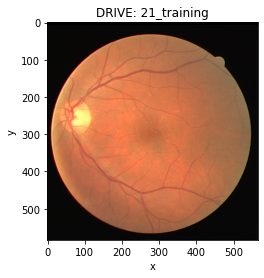

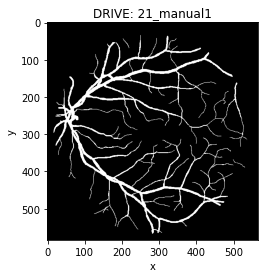

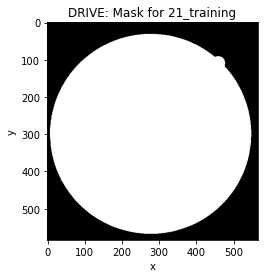

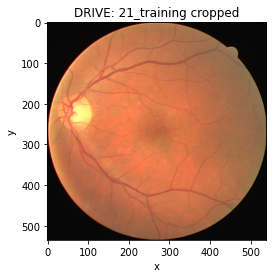

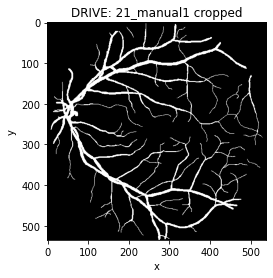

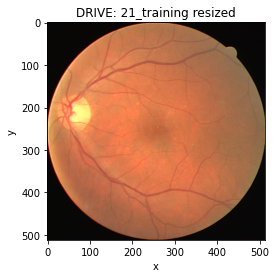

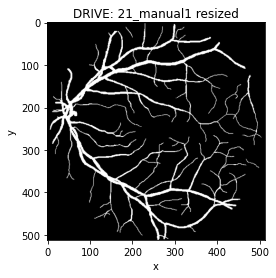

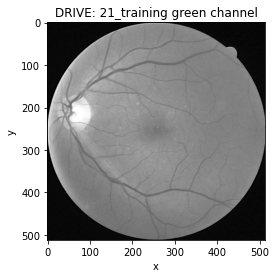

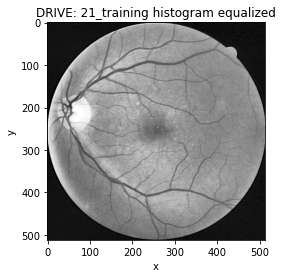

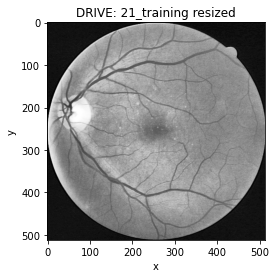

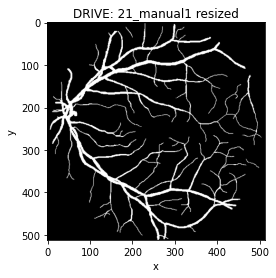

In [19]:
# testing of the different preprocessing steps for some particular images

FilePath_im = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/DRIVE/train/images/21_training.tif'
FilePath_annot = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/DRIVE/train/annotations/21_manual1.png'

# FilePath_im = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/STARE/training/images/im0001.ppm'
# FilePath_annot = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/STARE/training/annotations/im0001.ah.ppm'

# FilePath_im = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/CHASEDB1/train/images/Image_01L.jpg'
# FilePath_annot = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/CHASEDB1/train/annotations/Image_01L_1stHO.png'

# FilePath_im = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/IDRiD/HardExudates/train/images/IDRiD_01.jpg'
# FilePath_annot = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/IDRiD/HardExudates/train/annotations/IDRiD_01_EX.tif'

# FilePath_im = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/Kaggle/data/10_left.jpeg'

# load and display the image and annotation
im_array = LoadImage(FilePath_im)
annot_array = LoadImage(FilePath_annot)
PlotImage(im_array,'DRIVE', '21_training')
PlotImage(annot_array,'DRIVE', '21_manual1')

# define and visualize the mask for the image
mask = FindMask(im_array)
PlotImage(mask, database = 'DRIVE', image_name = 'Mask for 21_training')

# crop the image and annotation file and show them
crop_im_array = Cropping(im_array, mask)
crop_annot_array = Cropping(annot_array, mask, annotation = True)
PlotImage(crop_im_array,'DRIVE', '21_training cropped')
PlotImage(crop_annot_array,'DRIVE', '21_manual1 cropped')

# resize the image and annotation file and show them
resized_im_array = Resizing(crop_im_array, 512)
resized_annot_array = Resizing(crop_annot_array, 512)
PlotImage(resized_im_array,'DRIVE', '21_training resized')
PlotImage(resized_annot_array,'DRIVE', '21_manual1 resized')

# select a particular color channel
Green_channel_im = SelectChannel(resized_im_array, color = 'G')
PlotImage(Green_channel_im,'DRIVE', '21_training green channel')

# perform histogram equalization
Green_channel_im_equal = HistogramEqualization(Green_channel_im)
PlotImage(Green_channel_im_equal,'DRIVE', '21_training histogram equalized')

# do all preprocessing in 1 function
resized_im_array, resized_annot_array = Preprocessing(FilePath_im, 512, FilePath_annot, 'G')
PlotImage(resized_im_array[0,:,:],'DRIVE', '21_training resized')
PlotImage(resized_annot_array[0,:,:],'DRIVE', '21_manual1 resized')

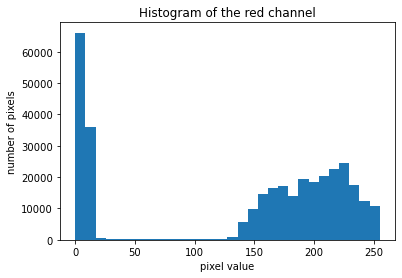

In [25]:
# visualization of the different pixel values, defining the background threshold
# make a histogram for the red channel of the image
FilePath_im = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/DRIVE/train/images/21_training.tif'
FilePath_annot = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/DRIVE/train/annotations/21_manual1.png'

im_array = LoadImage(FilePath_im)
red_channel = SelectChannel(im_array, 'R')
histogram, bins_list = np.histogram(red_channel, bins = 30)

# turn the 2D array into a 1D array
red_channel = red_channel.flatten()

# show the histogram
plt.figure()
plt.hist(red_channel, bins = bins_list) 
plt.title('Histogram of the red channel')
plt.xlabel('pixel value')
plt.ylabel('number of pixels')
plt.show()

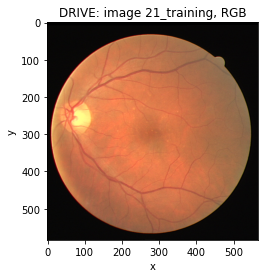

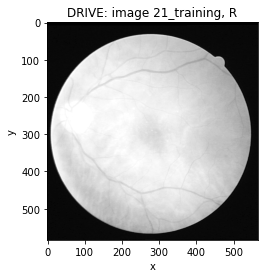

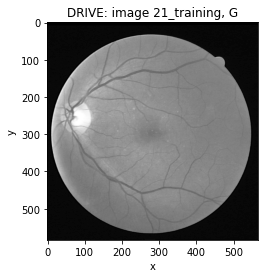

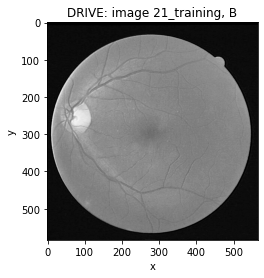

In [265]:
# example, visualization of the different color channels
FilePath = 'C:/Users/lunam/Documents/1steMaster/Stage/Data/DRIVE/train/images/21_training.tif'
im_array = LoadImage(FilePath)

store_path = 'C:/Users/lunam/Documents/1steMaster/Stage/Images_Report/RGB_Channels/'

PlotImage(im_array, 'DRIVE', 'image 21_training, RGB', save = True, savepath = store_path)
PlotImage(im_array[:,:,0], 'DRIVE', 'image 21_training, R', save = True, savepath = store_path)
PlotImage(im_array[:,:,1], 'DRIVE', 'image 21_training, G', save = True, savepath = store_path)
PlotImage(im_array[:,:,2], 'DRIVE', 'image 21_training, B', save = True, savepath = store_path)